In [1]:
# import torch
# import torchinfo


# net = MaskedAutoencoder()

# input_size = (10, 3, 32, 32)
# torchinfo.summary(net, input_size)

# Preapre data

In [2]:
import torch
import torchvision.transforms as T


SEED = 42
torch.manual_seed(SEED)

In [3]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader


batch_size = 256
# TODO: fix dataset loading
# TODO: add augmentations

train_data = CIFAR10('../data/', train=True, download=True, transform=T.ToTensor())
# train_data = train_data[:40000]

valid_data = CIFAR10('../data/', train=True, download=True, transform=T.ToTensor())
# valid_data = valid_data[40000:]

test_data = CIFAR10('../data/', train=False, download=True, transform=T.ToTensor())

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Train the autoencoder

In [4]:
from src.masked_autoencoder import MaskedAutoencoder

image_size = 32
patch_size = 8
num_patches = (image_size // patch_size) ** 2
in_chans = 3

encoder_embed_dim = 64
encoder_num_heads = 4
encoder_depth = 8

decoder_embed_dim = 64
decoder_num_heads = 4
decoder_depth = 4


net = MaskedAutoencoder(
    image_size,
    patch_size,
    in_chans,
    encoder_embed_dim,
    encoder_num_heads,
    encoder_depth,
    decoder_embed_dim,
    decoder_num_heads,
    decoder_depth,
)

In [5]:
from torch import optim


lr = 1e-3
betas = (0.9, 0.95)
num_epochs = 100

optimizer = optim.AdamW(net.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Set optimization scheduler
# total_steps = int((len(train_dataloader) / batch_size) * num_epochs)
# warmup_epoch_percentage = 0.15
# warmup_steps = int(total_steps * warmup_epoch_percentage)
# warmup_steps

# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, warmup_steps)

In [6]:
from src.plots import grid_plot
from torch.utils.tensorboard import SummaryWriter


log_writer = SummaryWriter()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
net.train()

step = 1
for epoch in range(num_epochs):
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        optimizer.zero_grad()
        loss, pred, mask = net(image_batch)
        loss.backward()
        optimizer.step()
        
        log_writer.add_scalar("Loss/train", loss.item(), step)
        
        # if step % 20 == 0:
        reconstructed = net.unpatchify(pred)
        grid = grid_plot(image_batch, reconstructed)
        log_writer.add_image('Original vs Reconstructed', grid, step)

        scheduler.step()

        step += 1
    print(epoch)
    

# log_writer.add_graph(net, batch)
log_writer.close()

2023-07-31 04:29:43.341970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0
1


KeyboardInterrupt: 

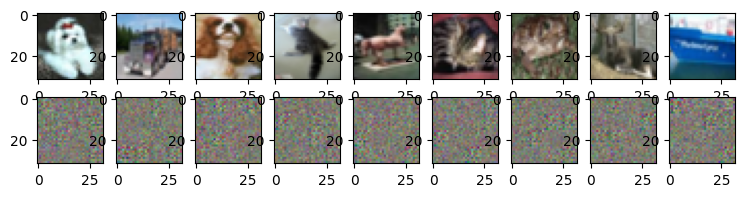

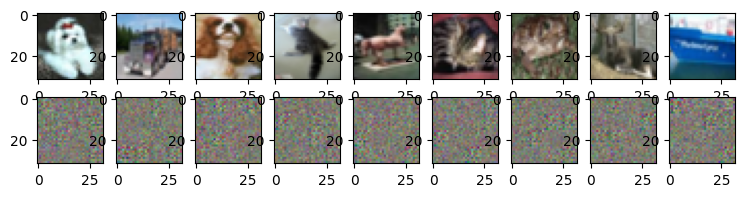

In [15]:
from src.plots import plot_reconstructed

plot_reconstructed(image_batch, reconstructed)

In [ ]:
# # evaluate accuracy after training
# model.eval()
# y_pred = model(X_test)
# acc = (y_pred.round() == y_test).float().mean()
# acc = float(acc)
# print("Model accuracy: %.2f%%" % (acc*100))

In [11]:
%tensorboard --logdir Tblogs/

UsageError: Line magic function `%tensorboard` not found.
